# **Intro and instructions**
This Jupyter Notebook serves as the user interface for the protein A bind and elute model.<br>
All data necessary for model configuration will be entered into this notebook and the simulation can be run from here.<br>
To use the protein A model, CADET and CADET-Process including pH dependent surface diffusion and the colloidal isotherm must be installed. <br>

Additionally, several modules (which are imported below), should be kept in the modules folder within this directory to run the model.<br>
If running inverse fitting and/or using a user defined pH profile, experimental data will need to be provided in an excel workbook, the format of which is described in the relevant section below.<br>
___

Necessary dependencies and modules are imported here.

In [1]:
import sys
import os
from pathlib import Path
from addict import Dict
sys.path.append(os.path.join(os.getcwd(), "../modules"))
import create_model_structure, CADET_Process_configuration, evaluate_sim, make_outputs
import CSTR_v240927 as CSTR
import resin_titration_diffeq_v240927 as titration

Creating the dictionary to store all inputs. (Do not edit)

In [2]:
inputs = Dict()
pH_sim = Dict()
fit = Dict()

___
## **Follow the instructions below to set up the protein A model.**

**First, decide on some settings.**<br>

**Choose whether to run only a breakthrough or a load-wash-elute process**<br>
To run a breakthrough (load and wash only), set subprocess to 'BTC'.<br>
To run a load-wash-elute process set subprocess to 'LWE'.<br>

In [3]:
subprocess = 'LWE'

**Choose whether to use constant parameters or pH dependent parameters**<br>
If only running a breakthrough simulation, you can use either the full set of pH dependent parameters (lnKe0, lnKe1, Bpp0, Bpp1, Ds0, Ds1, pore_diff) or constant parameters (lnKe, Bpp, pore_diff, with Ds=0).<br>
To use the full set of parameters, set use_pH_dependence=True<br>
To use only the constant parameters, set use_pH_dependence=False<br>

In [4]:
use_pH_dependence=True

**Set the type of elution H+ profile to use**<br>
Several options are available to define the elution profile.<br>
The profile variable can be set to the options described below.<br>
profile = 'step' : a simple step elution not accounting for buffer reactions or resin titration.<br>
profile = 'linear' : a linear elution gradient in H+ (not pH) not accounting for buffer reactions or resin titration.<br>
profile = 'simulated' : a simulated profile accounting for buffer reactions and resin titration.<br>
profile = 'user_defined' : a time series given by the user is used.<br>

In [5]:
profile = 'step'

If using a user_defined inlet profile, enter the name of the workbook here.<br>
The first column should be volume in mL and the second should be [H+] in mM.

In [6]:
#profile_path = r'example_inlet_profile.xlsx'

**Enter whether you would like to run a forward simulation or run inverse fitting.**<br>
Enter 'forward' or 'fit'.

In [7]:
inputs.run_type = 'forward'

**Set the elution pooling criteria.**<br>
Here, concentration is used similarly to how a UV cutoff would be, with cutoffs set separately for the start and end of collection in units of [mg/mL].

In [8]:
inputs.pool_start_conc = 5
inputs.pool_end_conc   = 5

**Set which range on the x-axis to plot in CVs (to zoom in on elution, for example)**

In [9]:
inputs.plot_start_CV = 0
inputs.plot_end_CV = 63

**Enter the process information.**<br>
To enable working with multiple experiments simultaneously, process conditions are entered as lists of the format: <br>[experiment 1, experiment 2, experiment 3, ...]

**Enter the step length in column volumes for each step in the method.**

In [10]:
inputs.load_CV = [38.24]
inputs.wash_CV = [20]
inputs.elution_CV = [5]

**Enter the residence time for each step in the method.**

In [11]:
inputs.load_RT = [2]
inputs.wash_RT = [2]
inputs.elution_RT = [2]

**Enter the pH for each step in the method.**

In [12]:
inputs.load_pH = [7.4]
inputs.wash_pH = [7.4]
inputs.elution_pH = [3.5]

**Enter the feed information.**<br>
The model is set up to work with multiple components. For calculation purposes, the monomer concentration should be listed first.

**Enter the protein molecular weights in kilodaltons with the monomer first and aggregate second**

In [13]:
inputs.molecular_weights = [148]

**Enter the concentrations of each species in the feed**<br>
Units should be mg/mL. Components should be entered as a nested list where the outer list corresponds to experiments while the inner lists correspond to components.<br>
format: [[exp1 comp1, exp1 comp2], [exp2 comp1, exp2 comp2] ...]

In [14]:
inputs.feed_conc = [[4.69,],]

**Enter the resin information.**<br>
Ee: Extra-particle porosity (usuall around 0.4) unitless <br>
Ep: Intra-particle porosity (usually around 0.7 - 0.95) unitless <br>
Particle_diameter: particle diameter in micrometers <br>
Phase_ratio: phase ratio in $m^2/m^3$ surface area per unit volume<br>

In [15]:
inputs.Ee = 0.34
inputs.Ep = 0.92
inputs.particle_diameter = 54.1
inputs.phase_ratio = 5.91e8

**Enter information about the column geometry.**<br>
col_id: column internal diameter in [cm]<br>
col_length: column length in [cm]

In [16]:
inputs.col_id = 0.5
inputs.col_length = 1.8

**Enter information about the system tubing.**<br><br>
Tubing is defined independently for the load and wash sections and for the elution section, reflecting that the flowpath is often different for these sections. Thus, the system hold-up-volume may be different for these two sections, and using different tubing sizes for each section allows this to be adjusted.
<div>
<center><img src="../figures/flow_diagram.png" width="500"/></center>
</div>
load_tubing_id: tubing internal diameter for load and wash sections in [mm]<br>
load_tubing_length: tubing length for load and wash sections in [cm]
<br><br>
elu_tubing_id: tubing internal diameter for elution section in [mm]<br>
elu_tubing_length: tubing length for elution section in [cm]
<br><br>
If you do not wish to include tubing in the model for either section, you can set the tubing length to 0 (This will remove the unit operation completely).

In [17]:
inputs.load_tubing_id = 0.25
inputs.load_tubing_length = 0
inputs.elu_tubing_id = 0.25
inputs.elu_tubing_length = 0

___
## **pH trace simulation**

The inputs in this section are only used if you are simulating the pH trace.

**Enter the volume of the mixer to use for pH trace simulation**<br>
A non-zero value is required here if using the simulated pH trace.<br>
This value should reflect the actual system mixer volume if there is one in line.

In [18]:
pH_sim.mixer_volume = 0.09

**Enter the concentrations for the wash buffer in [mM]**

In [19]:
pH_sim.wash_buffer.buffer1_total = 50
pH_sim.wash_buffer.buffer2_total = 0
pH_sim.wash_buffer.NaCl = 150
pH_sim.wash_buffer.Na = 150
pH_sim.wash_buffer.Cl = 193

**Enter the concentrations for the elution buffer in [mM]**

In [20]:
pH_sim.elution_buffer.buffer1_total = 0
pH_sim.elution_buffer.buffer2_total = 50
pH_sim.elution_buffer.NaCl = 50
pH_sim.elution_buffer.Na = 53.53
pH_sim.elution_buffer.Cl = 50

**Enter info for resin titration sim**

Enter the number of axial discretization cells to use for the resin titration simulation

In [21]:
pH_sim.N = 60

**Enter the ligand density in mM packed column and the pKa of the ligand for titration.**<br>
The ligand density can be approximated or measured via titration.<br>
An estimated average pKa of titratable amino acids, ~4.0, is used here.

In [22]:
pH_sim.ligand_density = 20 
pH_sim.ligand_pK = 4.0

**Enter chemical properties to use for the wash buffer**<br>
For example, for Tris buffer:<br>
wash_buffer.pKa = 8.07<br>
wash_buffer.zA = 1<br>

In [23]:
pH_sim.wash_buffer.pKa = 8.07
pH_sim.wash_buffer.zA = 1

**Enter chemical properties to use for the elution buffer**<br>
For example, for acetate buffer:<br>
elution_buffer.pKa = 4.76<br>
elution_buffer.zA = 0

In [24]:
pH_sim.elution_buffer.pKa = 4.76
pH_sim.elution_buffer.zA = 0

___
## **Forward simulation**
**If you are running a forward simulation, enter the parameter values for each component as a list.**<br>
format: [component 1, component 2, ...]

**Enter a value for pore diffusivity. This is the same whether use_pH_dependence is True or False**<br> 
pore_diff: # * 1e-12 [m^2/s] pore diffusivity

In [25]:
inputs.params.pore_diff = [1.54]

**If use_pH_dependence is False, enter values for lnke, Bpp, and Ds**<br>
lnKe: [-] equilibrium constant<br>
Bpp: [-] protein-protein interaction parameter<br>
Ds: # * 1e-12 [m^2/s] surface diffusivity (assume 0 for high pH)<br>

In [26]:
inputs.params.lnKe = [39.881]
inputs.params.Bpp = [25.082]
inputs.params.Ds = [0]

**If use_pH_dependence=True, enter values for all pH dependent parameters**<br>
lnKe0: [-] equilibrium constant base parameter<br>
lnKe1: [-] equilibrium  constant pH dependence parameter<br>
Bpp0: [-] protein-protein interaction base parameter<br>
Bpp1: [-] protein-protein interaction pH dependence parameter<br>
Ds0: # * 1e-12 [m^2/s] surface diffusivity base parameter<br>
Ds1: [-] surface diffusivity pH dependence parameter<br>

In [27]:
inputs.params.lnKe0 = [39.91]
inputs.params.lnKe1 = [-28.543]
inputs.params.Bpp0 = [8.7894]
inputs.params.Bpp1 = [-0.099]
inputs.params.Ds0 = [0.00051]
inputs.params.Ds1 = [93.031]

___
## **Fitting**
**If you are running inverse fitting, enter the path to the excel workbook containing the experimental data.**<br>
BE SURE TO INCLUDE THE FILE EXTENSION (.xlsx etc)
<br><br>
Experimental Input data should be collected in an excel file with the following format:
<div>
<center><img src="../figures/example_excel.png" width="500"/></center>
</div>
The first row will be skipped and can be used as a header, data should begin in the second row
To fit multiple experiments at once, add each experiment in a new sheet in the excel file.
<br><br>
The concentration curve could be created either by collecting fractions and measuring concentrations offline or by creating a calibration curve using a set of known concentration sample injections on the AKTA and using this calibration curve to convert UV signal to protein concentration.

In [28]:
fit.data_path = r'example_chromatogram.xlsx'

**Enter the concentration where saturation occurs or the calibration curve ends for each component.**<br>
Concentration values above this cutoff will not be used for fitting.<br>
If it is not an issue, this can be set to an arbitrary high value..

In [29]:
fit.conc_cutoff = [1000]

**Enter the bounds to use for each parameter and for each component that you would like to fit.**<br>
format: ((comp1_lower_bound, comp1_upper_bound), (comp2_lower_bound, comp2_upper_bound), ...)

<span style="color: red;">**Only enter bounds for the parameters that you want to fit. If bounds are supplied for a given parameter, the parameter will be fit. Otherwise, the value set in the Forward Simulation section will be used.**</span>

**Enter bounds for pore diffusivity. This is the same whether use_pH_dependence is True or False**<br> 
pore_diff: # * 1e-12 [m^2/s] pore diffusivity

In [30]:
fit.bounds.pore_diff = ((1, 6),)

**If use_pH_dependence is False, enter bounds for lnke, Bpp, and Ds**<br>
lnKe: [-] equilibrium constant<br>
Bpp: [-] protein-protein interaction parameter<br>
Ds: # * 1e-12 [m^2/s] surface diffusivity (assume 0 for high pH)<br>

In [31]:
fit.bounds.lnKe = ((25, 30),)
fit.bounds.Bpp = ((5, 14),)
#fit.bounds.Ds = ((0.01, 2),)

**If use_pH_dependence=True, enter bounds for pH dependent parameters**<br>
lnKe0: [-] equilibrium constant base parameter<br>
lnKe1: [-] equilibrium  constant pH dependence parameter<br>
Bpp0: [-] protein-protein interaction base parameter<br>
Bpp1: [-] protein-protein interaction pH dependence parameter<br>
Ds0: # * 1e-12 [m^2/s] surface diffusivity base parameter<br>
Ds1: [-] surface diffusivity pH dependence parameter<br>

In [32]:
fit.bounds.lnKe0 = ((30, 50),)
fit.bounds.lnKe1 = ((-30, -25),)
fit.bounds.Bpp0 = ((5, 14),)
fit.bounds.Bpp1 = ((-0.5, -0.001),)
#fit.bounds.Ds0 = ((1e-5, 2),)
#fit.bounds.Ds1 = ((10, 100),) 

# **Running the simulation**

You do not need to edit any of the cells below.<br><br>
Running the below cells will perform the last steps needed to run the simulation.
___

Here, the inputs are passed to the 'create_model_structure' module where preliminary calculations are performed.

In [33]:
if inputs.run_type == 'fit':
    inputs.update(fit)

if profile == 'simulated':
    inputs.update(pH_sim)
elif profile == 'user_defined':
    inputs.profile_path = profile_path
   
ms_list = create_model_structure.create_model_structures(inputs) 

A unique folder where the results of the current simulation will be stored is created.

In [34]:
folder = make_outputs.make_results_folder(inputs.run_type, os.getcwd())

If a simulated profile is being used, this will run the CSTR simulation.

In [35]:
if profile == 'simulated':
    for ms in ms_list:
        ms = CSTR.get_CSTR_profile(ms)
        CSTR.plot_CSTR(ms, folder)
        CSTR.make_excel(ms, folder)

If a simulated profile is being used, this will run the resin titration simulation.

In [36]:
if profile == 'simulated':
    for ms in ms_list:
        ms = titration.resin_titration(ms)
        titration.plot_titration(ms, folder)
        titration.make_excel(ms, folder)

Finally, run the CADET column simulation.


CADET-Process simulation running!

Simulation completed in 16.51 seconds.



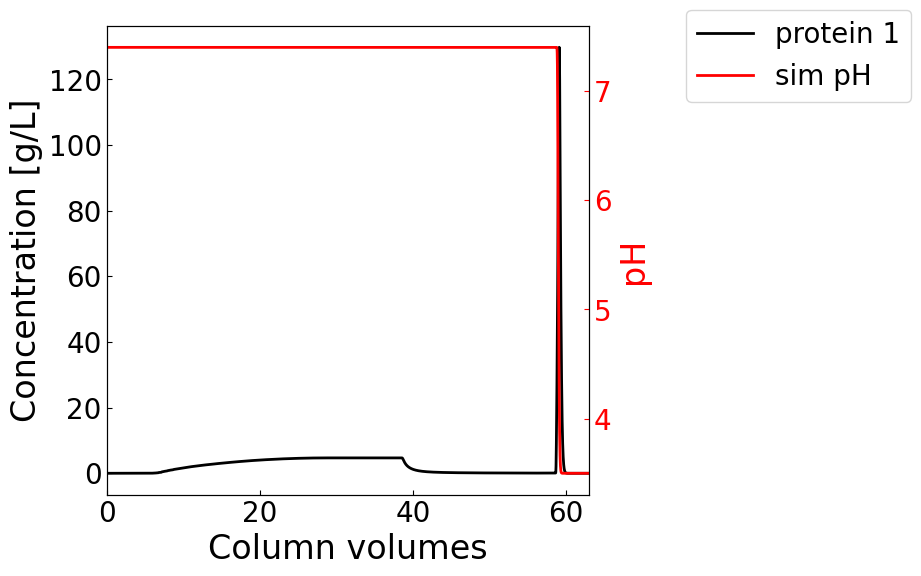

In [37]:
all_curves = []
all_results = []
for ms in ms_list:    
    sim_solution = CADET_Process_configuration.run(ms, subprocess=subprocess, profile=profile,
                                                   use_pH_dependence=use_pH_dependence,
                                                )
    
    simulation_curves = evaluate_sim.process_simulation_data(sim_solution, ms)
    results = evaluate_sim.evaluate_simulation(simulation_curves, ms)  
    all_curves.append(simulation_curves)
    all_results.append(results)

# make excel workbook outputs containing results for all experiments
make_outputs.make_excels(all_results, all_curves, folder)
make_outputs.make_plots(all_curves, ms_list, folder)